In [1]:
import sys, os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import pickle
from pathlib import Path

In [4]:

ROOT = Path.cwd().parents[0]
model_name="xgboost_panel_with_feat"
FEATURE_LIST_FILE = ROOT / "datamodel" / f"{model_name}.pkl"
MODEL_FILE = ROOT / "datamodel" / f"{model_name}.pkl"
RESULT_FILE = ROOT / 'datamodel' / f"{model_name}_pred.csv"
ENCODER_FILE  = ROOT / "datamodel" / f"{model_name}_label_enc.pkl"

In [5]:
from pathlib import Path
import geopandas as gpd

ROOT = Path.cwd().parents[0]
GEOJSON_FILE = ROOT / "datasets" / "raw" / "boroughs_montreal.geojson"
print("[Path exists?]", GEOJSON_FILE.exists(), "➜", GEOJSON_FILE)

zones_gdf = gpd.read_file(GEOJSON_FILE)
print(zones_gdf.columns)


[Path exists?] True ➜ c:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6\datasets\raw\boroughs_montreal.geojson
Index(['CODEID', 'NOM', 'NOM_OFFICIEL', 'CODEMAMH', 'CODE_3C', 'NUM', 'ABREV',
       'TYPE', 'COMMENT', 'DATEMODIF', 'geometry'],
      dtype='object')


In [6]:
df=pd.read_csv(RESULT_FILE)

C:\Users\mirei\AppData\Local\Temp\ipykernel_13044\3231598741.py:33: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


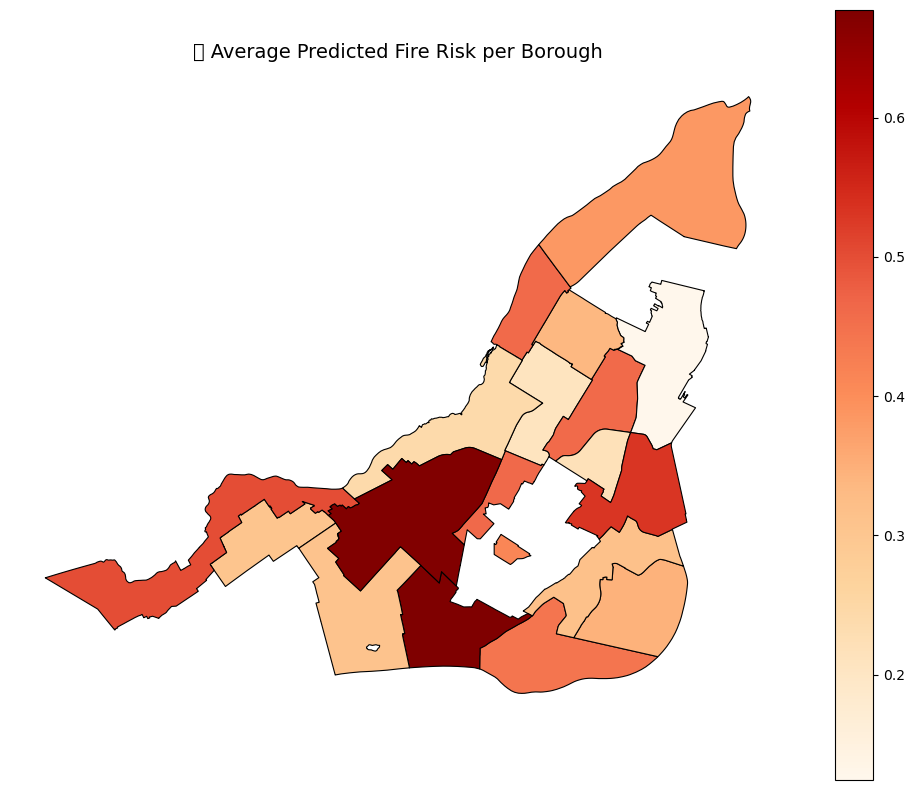

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 🔹 Load boroughs GeoJSON
boroughs_path = ROOT / "datasets" / "raw" / "boroughs_montreal.geojson"
zones_gdf = gpd.read_file(boroughs_path)

# 🔹 Create code → name mapping
code_to_name = dict(zip(zones_gdf["CODEID"], zones_gdf["NOM"]))

# 🔹 Replace numeric code with readable borough name
df["BOROUGH_NAME"] = df["NO_ARROND_ILE_CUM"].map(code_to_name)

# 🔹 Aggregate average predicted fire probability per borough
agg = df.groupby("BOROUGH_NAME")["predicted_proba"].mean().reset_index()

# 🔹 Merge with borough geometry for mapping
zones_gdf["BOROUGH_NAME"] = zones_gdf["NOM"]
map_df = zones_gdf.merge(agg, on="BOROUGH_NAME", how="left")

# 🔹 Plot
fig, ax = plt.subplots(figsize=(10, 8))
map_df.plot(
    column="predicted_proba", 
    cmap="OrRd", 
    linewidth=0.8, 
    edgecolor="black", 
    legend=True, 
    ax=ax
)
ax.set_title("🔥 Average Predicted Fire Risk per Borough", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


Fix missing boroughs values

Buildings missing borough name after spatial join: 0


C:\Users\mirei\AppData\Local\Temp\ipykernel_13044\536397634.py:55: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


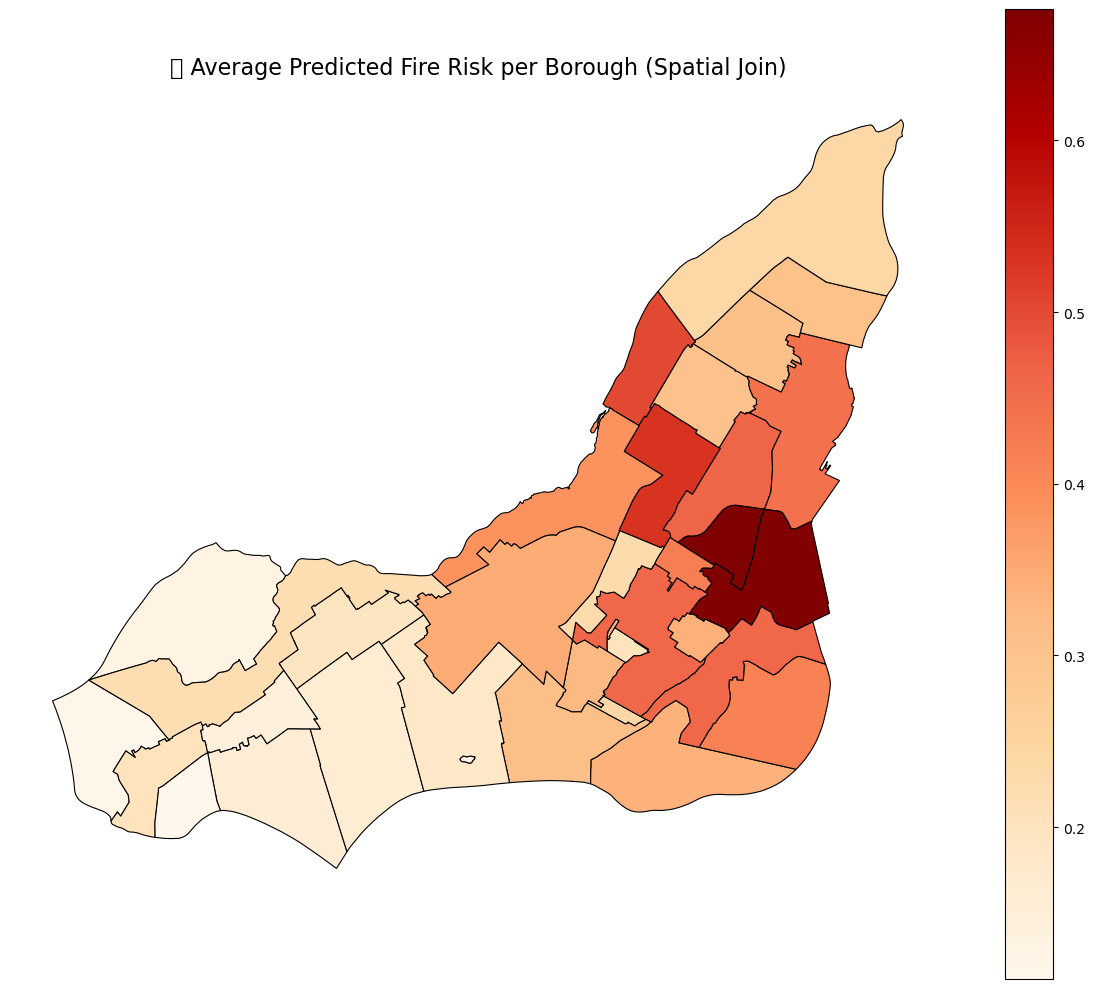

In [8]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pathlib import Path

# Paths
ROOT = Path.cwd().parents[0]
PRED_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
BOROUGH_FILE = ROOT / "datasets" / "raw" / "boroughs_montreal.geojson"

# Load prediction data
df = pd.read_csv(PRED_FILE, usecols=["ID_UEV", "NO_ARROND_ILE_CUM", "LATITUDE", "LONGITUDE", "predicted_proba"])

# Drop rows with missing coords or predicted prob
df = df.dropna(subset=["LATITUDE", "LONGITUDE", "predicted_proba"])

# Convert prediction df to GeoDataFrame with points
geometry = gpd.points_from_xy(df["LONGITUDE"], df["LATITUDE"])
buildings_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Load borough shapefile and reproject to EPSG:4326 if needed
zones_gdf = gpd.read_file(BOROUGH_FILE)
if zones_gdf.crs != buildings_gdf.crs:
    zones_gdf = zones_gdf.to_crs(buildings_gdf.crs)

# Spatial join: assign borough name by point location
buildings_with_borough = gpd.sjoin(buildings_gdf, zones_gdf[["CODEID", "NOM", "geometry"]], how="left", predicate="within")
buildings_with_borough = buildings_with_borough.rename(columns={"NOM": "BOROUGH_NAME"})

# Check missing boroughs after join
missing_boroughs_count = buildings_with_borough["BOROUGH_NAME"].isna().sum()
print(f"Buildings missing borough name after spatial join: {missing_boroughs_count}")

# Aggregate average predicted fire risk by borough
agg_risk = buildings_with_borough.groupby("BOROUGH_NAME")["predicted_proba"].mean().reset_index()

# Merge aggregated risk with borough polygons for plotting
zones_gdf["BOROUGH_NAME"] = zones_gdf["NOM"]
map_df = zones_gdf.merge(agg_risk, on="BOROUGH_NAME", how="left")

# Plot map
fig, ax = plt.subplots(figsize=(12, 10))
map_df.plot(
    column="predicted_proba",
    cmap="OrRd",
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "No data"}
)
ax.set_title("🔥 Average Predicted Fire Risk per Borough (Spatial Join)", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
import geopandas as gpd
import folium
from branca.colormap import linear
from pathlib import Path

# ------------------------------
# 📁 Load spatially joined buildings with boroughs
# ------------------------------
# Assuming you have already done spatial join and have this GeoDataFrame:
# buildings_with_borough = gpd.read_file("path_to_spatial_joined_buildings.geojson") 
# or created in memory

# For example, if you have CSV + geometry separately:
# buildings_with_borough = gpd.read_file("your_joined_file.geojson") 

# ------------------------------
# Aggregate average fire risk by borough
# ------------------------------
agg_risk = buildings_with_borough.groupby("BOROUGH_NAME")["predicted_proba"].mean().reset_index()
agg_risk.rename(columns={"predicted_proba": "avg_predicted_proba"}, inplace=True)

# ------------------------------
# Load borough boundaries (GeoDataFrame)
# ------------------------------
ROOT = Path.cwd().parents[0]
boroughs_path = ROOT / "datasets" / "raw" / "boroughs_montreal.geojson"
boroughs_gdf = gpd.read_file(boroughs_path).to_crs("EPSG:4326")
boroughs_gdf["BOROUGH_NAME"] = boroughs_gdf["NOM"]

# ------------------------------
# Merge borough boundaries with aggregated risk
# ------------------------------
map_gdf = boroughs_gdf.merge(agg_risk, on="BOROUGH_NAME", how="left")

# ------------------------------
# Fix serialization issues: convert datetime columns to string
# ------------------------------
for col in map_gdf.columns:
    if pd.api.types.is_datetime64_any_dtype(map_gdf[col]):
        map_gdf[col] = map_gdf[col].astype(str)

# Create formatted risk for tooltips
map_gdf["formatted_risk"] = map_gdf["avg_predicted_proba"].apply(
    lambda x: f"{x:.2%}" if pd.notnull(x) else "N/A"
)

# ------------------------------
# Create Folium map with choropleth
# ------------------------------
m = folium.Map(location=[45.5017, -73.5673], zoom_start=11, tiles="CartoDB positron")

# Color scale for risk
colormap = linear.OrRd_09.scale(
    map_gdf["avg_predicted_proba"].min(),
    map_gdf["avg_predicted_proba"].max()
)
colormap.caption = "🔥 Average Predicted Fire Risk"
colormap.add_to(m)

# Add borough polygons colored by risk
folium.GeoJson(
    data=map_gdf,
    style_function=lambda feature: {
        "fillColor": colormap(feature["properties"]["avg_predicted_proba"]) if feature["properties"]["avg_predicted_proba"] is not None else "lightgray",
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.7,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["BOROUGH_NAME", "formatted_risk"],
        aliases=["Borough", "Avg Fire Risk"],
        localize=True,
        sticky=True
    )
).add_to(m)

# ------------------------------
# Save the map
# ------------------------------
output_file = ROOT / "datamodel" / "fire_risk_by_borough_map.html"
m.save(str(output_file))
print(f"✅ Map saved as {output_file}")


✅ Map saved as c:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6\datamodel\fire_risk_by_borough_map.html


In [12]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from pathlib import Path

# ------------------------------
# 📁 Load building-level predictions
# ------------------------------
ROOT = Path.cwd().parents[0]
BUILDING_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
df = pd.read_csv(BUILDING_FILE)

# ------------------------------
# 🧼 Filter valid points & take top 7500 highest risk
# ------------------------------
df = df.dropna(subset=["LATITUDE", "LONGITUDE", "predicted_proba"])
top_buildings = df.sort_values("predicted_proba", ascending=False).head(7500)

# ------------------------------
# 🌍 Create Folium Map
# ------------------------------
m = folium.Map(location=[45.5017, -73.5673], zoom_start=11, tiles="CartoDB positron")

# 🔘 Add clustered markers
marker_cluster = MarkerCluster().add_to(m)

for _, row in top_buildings.iterrows():
    folium.CircleMarker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        radius=3,
        color="red",
        fill=True,
        fill_opacity=0.7,
        tooltip=f"Risk: {row['predicted_proba']:.2%}"
    ).add_to(marker_cluster)

# ------------------------------
# 💾 Save map
# ------------------------------
m.save("building_level_fire_risk_map.html")
print("✅ Saved interactive map with top 7500 buildings as 'building_level_fire_risk_map.html'")


✅ Saved interactive map with top 7500 buildings as 'building_level_fire_risk_map.html'


In [13]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from pathlib import Path

# 📁 Load data
ROOT = Path.cwd().parents[0]
PRED_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
df = pd.read_csv(PRED_FILE, usecols=["ID_UEV", "predicted_proba", "LATITUDE", "LONGITUDE"])

# 🧼 Filter valid rows
df = df.dropna(subset=["LATITUDE", "LONGITUDE", "predicted_proba"])
df = df[df["predicted_proba"] > 0]

# 🔝 Top 100 by fire risk
top_100 = df.sort_values("predicted_proba", ascending=False).head(100)
top_100["formatted_risk"] = top_100["predicted_proba"].apply(lambda x: f"{x:.2%}")

# 🌍 Create map
m = folium.Map(location=[45.5017, -73.5673], zoom_start=12, tiles="CartoDB positron")
marker_cluster = MarkerCluster().add_to(m)

# 🧷 Add markers
for _, row in top_100.iterrows():
    tooltip = f"<b>Risk:</b> {row['formatted_risk']}<br><b>ID:</b> {row['ID_UEV']}"
    folium.CircleMarker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        radius=5,
        color="darkred",
        fill=True,
        fill_color="darkred",
        fill_opacity=0.8,
        tooltip=tooltip
    ).add_to(marker_cluster)

# 💾 Save map
output_path = ROOT / "datamodel" / "top_100_fire_risk_map.html"
m.save(str(output_path))
print("✅ Map saved to:", output_path)


✅ Map saved to: c:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6\datamodel\top_100_fire_risk_map.html


In [14]:
import pandas as pd
import folium
from pathlib import Path

# 📁 Load data
ROOT = Path.cwd().parents[0]
PRED_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
df = pd.read_csv(PRED_FILE, usecols=["ID_UEV", "predicted_proba", "LATITUDE", "LONGITUDE"])

# 🧼 Filter valid rows
df = df.dropna(subset=["LATITUDE", "LONGITUDE", "predicted_proba"])
df = df[df["predicted_proba"] > 0]

# 🔝 Top 100 by fire risk
top_100 = df.sort_values("predicted_proba", ascending=False).head(100)
top_100["formatted_risk"] = top_100["predicted_proba"].apply(lambda x: f"{x:.2%}")

# 🌍 Create base map
m = folium.Map(location=[45.5017, -73.5673], zoom_start=12, tiles="CartoDB positron")

# ➕ Add each building as a separate circle marker
for _, row in top_100.iterrows():
    folium.CircleMarker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        radius=6,
        fill=True,
        fill_opacity=0.8,
        color="darkred",
        fill_color="darkred",
        tooltip=folium.Tooltip(f"<b>Risk:</b> {row['formatted_risk']}<br><b>ID:</b> {row['ID_UEV']}")
    ).add_to(m)

# 💾 Save map
output_path = ROOT / "datamodel" / "top_100_fire_risk_individual_map.html"
m.save(str(output_path))
print("✅ Map saved to:", output_path)


✅ Map saved to: c:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6\datamodel\top_100_fire_risk_individual_map.html


Buildings missing borough name after spatial join: 0


C:\Users\mirei\AppData\Local\Temp\ipykernel_13044\1699904375.py:71: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


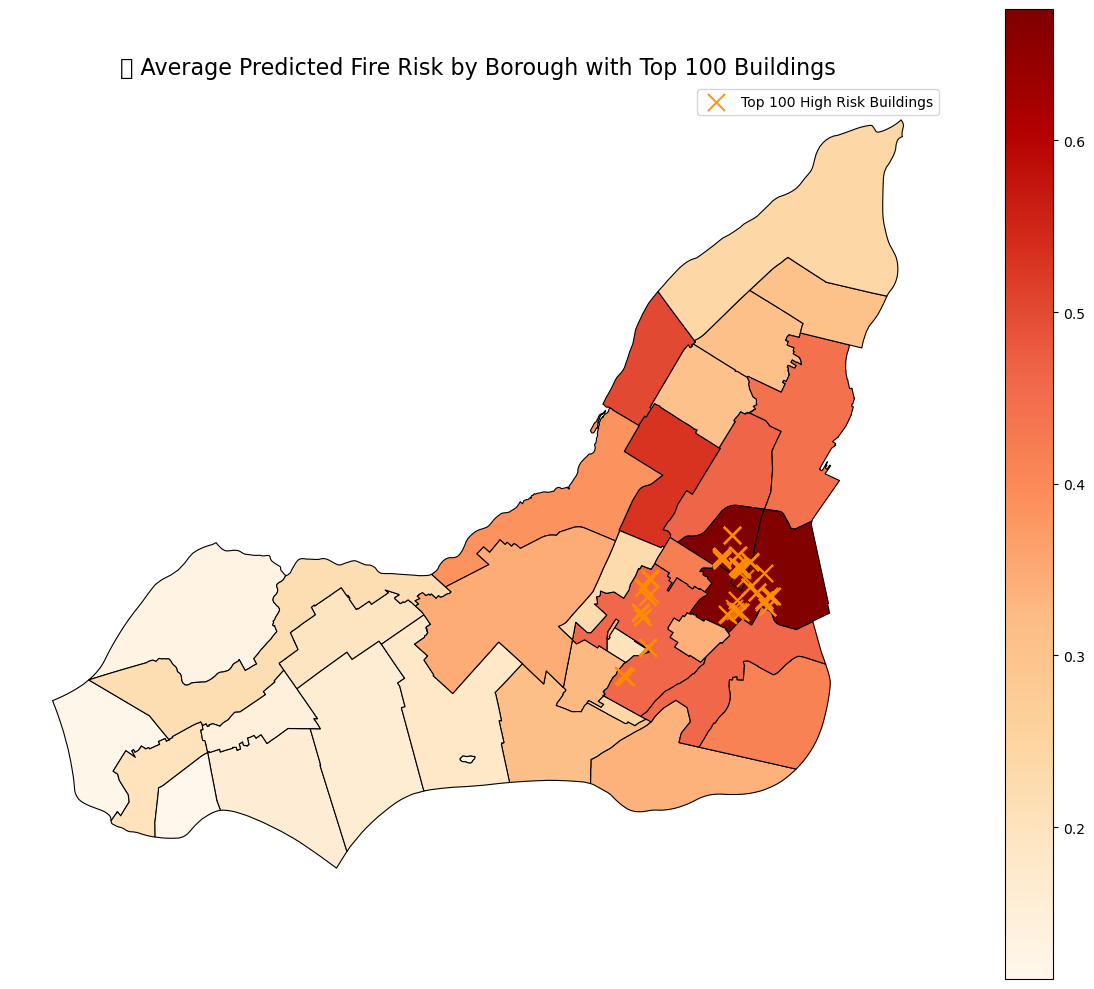

In [21]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pathlib import Path

# Paths
ROOT = Path.cwd().parents[0]
PRED_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
BOROUGH_FILE = ROOT / "datasets" / "raw" / "boroughs_montreal.geojson"

# Load prediction data
df = pd.read_csv(PRED_FILE, usecols=["ID_UEV", "NO_ARROND_ILE_CUM", "LATITUDE", "LONGITUDE", "predicted_proba"])
df = df.dropna(subset=["LATITUDE", "LONGITUDE", "predicted_proba"])

# Convert prediction df to GeoDataFrame with points
geometry = gpd.points_from_xy(df["LONGITUDE"], df["LATITUDE"])
buildings_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Load borough shapefile and reproject to EPSG:4326 if needed
zones_gdf = gpd.read_file(BOROUGH_FILE)
if zones_gdf.crs != buildings_gdf.crs:
    zones_gdf = zones_gdf.to_crs(buildings_gdf.crs)

# Spatial join: assign borough name by point location
buildings_with_borough = gpd.sjoin(buildings_gdf, zones_gdf[["CODEID", "NOM", "geometry"]], how="left", predicate="within")
buildings_with_borough = buildings_with_borough.rename(columns={"NOM": "BOROUGH_NAME"})

# Check missing boroughs after join
missing_boroughs_count = buildings_with_borough["BOROUGH_NAME"].isna().sum()
print(f"Buildings missing borough name after spatial join: {missing_boroughs_count}")

# Aggregate average predicted fire risk by borough
agg_risk = buildings_with_borough.groupby("BOROUGH_NAME")["predicted_proba"].mean().reset_index()

# Merge aggregated risk with borough polygons for plotting
zones_gdf["BOROUGH_NAME"] = zones_gdf["NOM"]
map_df = zones_gdf.merge(agg_risk, on="BOROUGH_NAME", how="left")

# Prepare plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot boroughs colored by average predicted risk
choropleth = map_df.plot(
    column="predicted_proba",
    cmap="OrRd",
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "No data"}
)

# Plot top 100 buildings with highest predicted risk as orange stars
top_100 = buildings_with_borough.nlargest(100, "predicted_proba")

top_100.plot(
    ax=choropleth,
    marker="x",
    color="darkorange",
    markersize=150,  # bigger stars
    label="Top 100 High Risk Buildings",
    alpha=0.9
)

# Add legend and title
plt.legend()
ax.set_title("🔥 Average Predicted Fire Risk by Borough with Top 100 Buildings", fontsize=16)
ax.axis("off")

plt.tight_layout()
plt.show()


In [23]:
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from branca.colormap import linear
from pathlib import Path

# Paths
ROOT = Path.cwd().parents[0]
PRED_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
BOROUGH_FILE = ROOT / "datasets" / "raw" / "boroughs_montreal.geojson"

# Load prediction data (only needed columns)
df = pd.read_csv(PRED_FILE, usecols=["ID_UEV", "NO_ARROND_ILE_CUM", "LATITUDE", "LONGITUDE", "predicted_proba"])
df = df.dropna(subset=["LATITUDE", "LONGITUDE", "predicted_proba"])

# Convert predictions DataFrame to GeoDataFrame
geometry = gpd.points_from_xy(df["LONGITUDE"], df["LATITUDE"])
buildings_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Load borough shapefile and ensure same CRS
zones_gdf = gpd.read_file(BOROUGH_FILE)
if zones_gdf.crs != buildings_gdf.crs:
    zones_gdf = zones_gdf.to_crs(buildings_gdf.crs)

# Spatial join: assign borough name to buildings by their location
buildings_with_borough = gpd.sjoin(
    buildings_gdf,
    zones_gdf[["CODEID", "NOM", "geometry"]],
    how="left",
    predicate="within"
).rename(columns={"NOM": "BOROUGH_NAME"})

# Check missing borough names
missing_boroughs_count = buildings_with_borough["BOROUGH_NAME"].isna().sum()
print(f"Buildings missing borough name after spatial join: {missing_boroughs_count}")

# Aggregate average predicted fire risk by borough
agg_risk = buildings_with_borough.groupby("BOROUGH_NAME")["predicted_proba"].mean().reset_index()

# Merge aggregated risk with borough polygons
zones_gdf["BOROUGH_NAME"] = zones_gdf["NOM"]
map_df = zones_gdf.merge(agg_risk, on="BOROUGH_NAME", how="left")

# Convert any datetime columns to string to avoid JSON serialization errors
for col in map_df.columns:
    if pd.api.types.is_datetime64_any_dtype(map_df[col]):
        map_df[col] = map_df[col].astype(str)

# Format risk for tooltip
map_df["formatted_risk"] = map_df["predicted_proba"].apply(
    lambda x: f"{x:.2%}" if pd.notnull(x) else "N/A"
)

# Create folium map centered on Montreal
m = folium.Map(location=[45.5017, -73.5673], zoom_start=11, tiles="CartoDB positron")

# Create a colormap for borough fire risk
colormap = linear.OrRd_09.scale(
    map_df["predicted_proba"].min(),
    map_df["predicted_proba"].max()
)
colormap.caption = "🔥 Average Predicted Fire Risk by Borough"
colormap.add_to(m)

# Add borough polygons colored by average predicted fire risk
folium.GeoJson(
    map_df,
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['predicted_proba']) if feature['properties']['predicted_proba'] is not None else 'lightgray',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["BOROUGH_NAME", "formatted_risk"],
        aliases=["Borough", "Avg Fire Risk"],
        localize=True,
        sticky=True
    ),
    name="Borough Risk"
).add_to(m)

# Add top 100 highest-risk buildings as yellow circle markers with clustering
top_100 = buildings_with_borough.nlargest(100, "predicted_proba")

marker_cluster = MarkerCluster(name="Top 100 High-Risk Buildings").add_to(m)
for _, row in top_100.iterrows():
    folium.CircleMarker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        radius=6,
        color="yellow",
        fill=True,
        fill_color="yellow",
        fill_opacity=0.8,
        tooltip=(
            f"<b>ID:</b> {row['ID_UEV']}<br>"
            f"<b>Risk:</b> {row['predicted_proba']:.2%}<br>"
            f"<b>Borough:</b> {row['BOROUGH_NAME']}"
        )
    ).add_to(marker_cluster)

# Add layer control
folium.LayerControl().add_to(m)

# Save the map
output_file = ROOT / "datamodel" / "fire_risk_borough_and_buildings.html"
m.save(str(output_file))
print(f"✅ Map saved to: {output_file}")


Buildings missing borough name after spatial join: 0
✅ Map saved to: c:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6\datamodel\fire_risk_borough_and_buildings.html


✅ Map saved to: c:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6\datamodel\fire_risk_borough_plus_top300.html


In [24]:
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from branca.colormap import linear
from pathlib import Path
from jinja2 import Template

# Paths
ROOT = Path.cwd().parents[0]
PRED_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
BOROUGH_FILE = ROOT / "datasets" / "raw" / "boroughs_montreal.geojson"

# Load prediction data
df = pd.read_csv(PRED_FILE, usecols=["ID_UEV", "NO_ARROND_ILE_CUM", "LATITUDE", "LONGITUDE", "predicted_proba"])
df = df.dropna(subset=["LATITUDE", "LONGITUDE", "predicted_proba"])

# Convert to GeoDataFrame
geometry = gpd.points_from_xy(df["LONGITUDE"], df["LATITUDE"])
buildings_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Load borough shapefile
zones_gdf = gpd.read_file(BOROUGH_FILE)
if zones_gdf.crs != buildings_gdf.crs:
    zones_gdf = zones_gdf.to_crs(buildings_gdf.crs)

# Spatial join to assign borough names
buildings_with_borough = gpd.sjoin(
    buildings_gdf,
    zones_gdf[["CODEID", "NOM", "geometry"]],
    how="left",
    predicate="within"
).rename(columns={"NOM": "BOROUGH_NAME"})

# Aggregate average risk by borough
agg_risk = buildings_with_borough.groupby("BOROUGH_NAME")["predicted_proba"].mean().reset_index()

# Merge with borough polygons
zones_gdf["BOROUGH_NAME"] = zones_gdf["NOM"]
map_df = zones_gdf.merge(agg_risk, on="BOROUGH_NAME", how="left")

# Convert datetime columns to string (to avoid folium errors)
for col in map_df.columns:
    if pd.api.types.is_datetime64_any_dtype(map_df[col]):
        map_df[col] = map_df[col].astype(str)

# Format risk for tooltip
map_df["formatted_risk"] = map_df["predicted_proba"].apply(lambda x: f"{x:.2%}" if pd.notnull(x) else "N/A")

# Create folium map
m = folium.Map(location=[45.5017, -73.5673], zoom_start=11, tiles="CartoDB positron")

# Colormap
colormap = linear.OrRd_09.scale(
    map_df["predicted_proba"].min(),
    map_df["predicted_proba"].max()
)
colormap.caption = "🔥 Avg Predicted Fire Risk by Borough"
colormap.add_to(m)

# Add borough polygons colored by risk
folium.GeoJson(
    map_df,
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['predicted_proba']) if feature['properties']['predicted_proba'] is not None else 'lightgray',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["BOROUGH_NAME", "formatted_risk"],
        aliases=["Borough", "Avg Fire Risk"],
        localize=True,
        sticky=True
    ),
    name="Borough Risk"
).add_to(m)

# List of top-k values for filtering
top_k_list = [100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000]

# Create feature groups for each top_k, add markers for top_k buildings
feature_groups = {}
for k in top_k_list:
    fg = folium.FeatureGroup(name=f"Top {k} Buildings", show=(k==top_k_list[0]))  # show only first by default
    marker_cluster = MarkerCluster().add_to(fg)
    top_k_buildings = buildings_with_borough.nlargest(k, "predicted_proba")
    for _, row in top_k_buildings.iterrows():
        folium.CircleMarker(
            location=[row["LATITUDE"], row["LONGITUDE"]],
            radius=5,
            color="yellow",
            fill=True,
            fill_color="yellow",
            fill_opacity=0.8,
            tooltip=(
                f"<b>ID:</b> {row['ID_UEV']}<br>"
                f"<b>Risk:</b> {row['predicted_proba']:.2%}<br>"
                f"<b>Borough:</b> {row['BOROUGH_NAME']}"
            )
        ).add_to(marker_cluster)
    fg.add_to(m)
    feature_groups[k] = fg

# Add Layer control
folium.LayerControl(collapsed=False).add_to(m)

# Add a dropdown menu for selecting the top k layer (using custom HTML/JS)
dropdown_html = """
<div style="position: fixed; top: 10px; left: 50px; z-index:9999; background-color:white; padding:10px; border-radius:5px;">
  <label for="topKSelect"><b>Select Top K Buildings:</b></label>
  <select id="topKSelect" onchange="updateTopK()">
    {% for k in top_k_list %}
    <option value="{{k}}" {% if loop.first %}selected{% endif %}>Top {{k}}</option>
    {% endfor %}
  </select>
</div>

<script>
function updateTopK() {
  var select = document.getElementById('topKSelect');
  var selected = select.value;

  {% for k in top_k_list %}
  var layer{{k}} = {{ feature_groups[k]._name }};
  if (selected == '{{k}}') {
    map.addLayer(layer{{k}});
  } else {
    map.removeLayer(layer{{k}});
  }
  {% endfor %}
}
</script>
"""

from branca.element import Template, MacroElement

template = Template(dropdown_html)
template.render(top_k_list=top_k_list, feature_groups=feature_groups)
macro = MacroElement()
macro._template = template
m.get_root().add_child(macro)

# Save map
output_file = ROOT / "datamodel" / "fire_risk_borough_buildings_dropdown.html"
m.save(str(output_file))
print(f"✅ Map saved to {output_file}")


✅ Map saved to c:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6\datamodel\fire_risk_borough_buildings_dropdown.html
